# Init 

In [1]:
import sys
import os
import json
from pathlib import Path
import tensorflow as tf
from keras import backend as K
import numpy as np

from keras.optimizers.legacy import Adam, SGD

from utils.loss import *
from utils.metrics import *
from utils.dataset import *
from keras.layers import *
from keras.models import *

base_path = '/Users/lorenzofederici/Univpm/Tesi/LUS-multitask-learning'
if base_path not in sys.path:
    sys.path.append(base_path)

# import custom lib
from src.utils.dataset import *
from src.experiment import Experiment
from models import resnet18 as r

gpu = len(tf.config.list_physical_devices('GPU'))>0
if gpu:
    tf.config.set_visible_devices([tf.config.list_physical_devices('GPU')[0],tf.config.list_physical_devices('CPU')[0]])
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("---> GPU is available <---")

exps_path = '/Users/lorenzofederici/Univpm/Tesi/LUS-multitask-learning/config/params.json'

with open(exps_path) as f:
    configs = json.load(f)

---> GPU is available <---


In [2]:
experiment = Experiment(base_path, output_mode= (True,True))
# TODO: chiedi a edo di smote



------------------------------------------------------------------------------------------
>> EXPERIMENT: exp_classification_ResNet_BS16_EP25_OPTAdam_LR0.0001_AUGFalse__DT1811_1650 <<
------------------------------------------------------------------------------------------
230 videos (2154 frames) loaded from cached data.
>>Setting:  {'IMG_SHAPE': 224, 'N_CLASS': 4, 'SEED': 42}
>>Experiment:  [{'backbone': 'ResNet', 'task': 'classification', 'out_class': 4, 'batch_size': 16, 'epoch': 25, 'split_ratio': [0.6, 0.2, 0.2], 'optimizer': 'Adam', 'lr': 0.0001, 'augmentation': False}]

>> SPLITTING:
>>> Dataset Split: Train=1265(59%), Val=430(20%), Test=459(21%)
>>> Train Class Weights: {0: 0.8433333333333334, 1: 1.15, 2: 0.6757478632478633, 3: 2.151360544217687}
>>> Val Class Weights: {0: 0.5569948186528497, 1: 2.193877551020408, 2: 0.7363013698630136, 3: 2.5595238095238093}
>>> Test Class Weights: {0: 0.8627819548872181, 1: 1.136138613861386, 2: 0.7403225806451613, 3: 1.6392857142857142}


2023-11-18 16:50:14.803266: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-18 16:50:14.803297: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-18 16:50:14.803301: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-18 16:50:14.803339: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-18 16:50:14.803361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


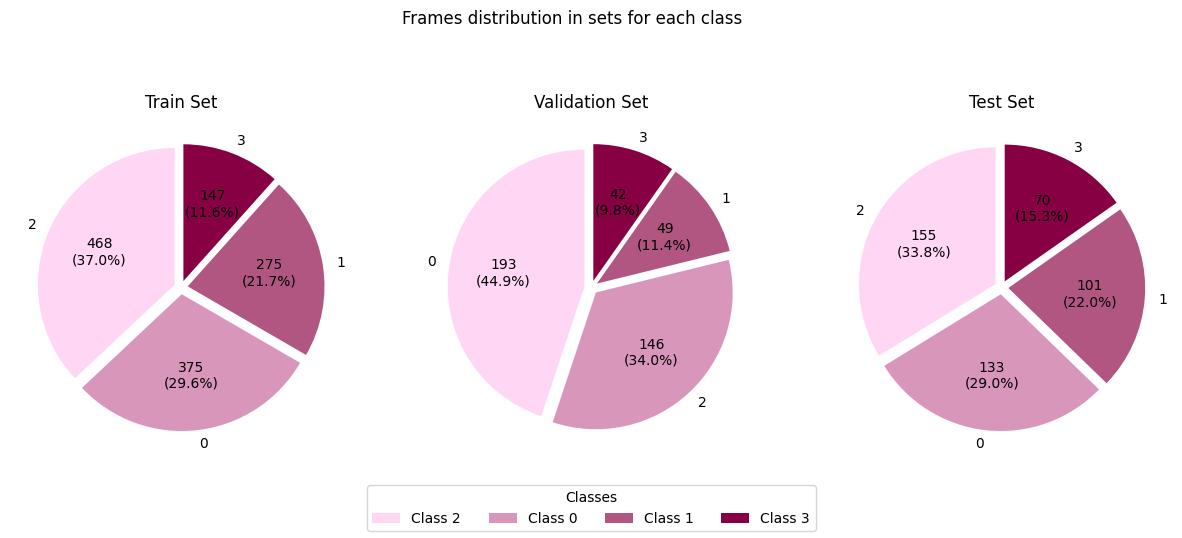

In [3]:
idx = 3
configs_general = configs['SETTING']
configs_exps    = configs['EXPS'][idx]

for config in configs_exps:
    experiment.build_experiment(configs_general, config)

print('>>Setting: ', configs_general)
print('>>Experiment: ', configs_exps)

experiment.split_dataset()
experiment.generate_split_charts('pierclass')

# Model

In [4]:
#load the model architecure and saved best weight
from tensorflow.keras.models import load_model
model_path = 'ResNet.hdf5'
# model_path = f"{model_path}/{MODEL}.hdf5"

In [5]:
if os.path.exists(model_path):
    print(f"Il file esiste.")
else:
    print(f"Il file non esiste.")


Il file esiste.


In [6]:
model = load_model(model_path, compile=True)

In [7]:
batch_size = experiment.exp_config['batch_size']
test_samples = len(experiment.test_subset_idxs)
test_steps = test_samples // batch_size
if test_samples % batch_size != 0:
    test_steps += 1

eval = model.evaluate(
    experiment.test_ds,
    batch_size=batch_size,
    # sample_weight=experiment.class_weight_dicts[2],
    steps=test_steps,
    workers=1,
    use_multiprocessing=False,
    return_dict=True
)

df = pd.DataFrame([eval])
df.to_csv('./results.csv', index=False)

2023-11-18 16:50:32.699755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 7269s 259s/step - loss: 0.7926 - accuracy: 0.7669


NameError: name 'pd' is not defined

In [ ]:
test_prediction = model.predict(
    experiment.test_ds,
    batch_size=batch_size,
    steps=test_steps,
    callbacks=None,
    workers=1,
    use_multiprocessing=False
)

In [ ]:
score_test = experiment.y_test_ds
pred_score = tf.argmax(test_prediction, axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Test Set Confusion Matrix
cf_matrix_test = confusion_matrix(score_test, pred_score, normalize='true', labels=[list(range(experiment.n_class))])

ax = sns.heatmap(cf_matrix_test, linewidths=1, annot=True, fmt='.2f', cmap="BuPu")
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Test Set Confusion Matrix')
plt.show()